# Task11 XGBoost算法分析与案例调参实例

## 1 知识梳理

### 1.1 XGBoost算法

- 简介：XGBoost是一个在Gradient Boosting框架下、优化的分布式梯度增强库，提供了并行树提升（也称为GBDT，GBM），可使用分布式环境（Hadoop，SGE，MPI）运行；以CART决策树为子模型，通过Gradient Tree Boosting实现多棵CART树的集成学习，得到最终模型

- 算法步骤：
  1. 构造目标函数：$$\mathcal{L}(\phi)=\sum_{i} l\left(\hat{y}_{i}, y_{i}\right)+\sum_{k} \Omega\left(f_{k}\right)$$其中，$\displaystyle \sum_{i} l\left(\hat{y}_{i}, y_{i}\right)$为损失函数，$\displaystyle \sum_{k} \Omega\left(f_{k}\right)$为正则化项
  2. 叠加式的训练：通过目标函数分解及优化，可得$$\mathcal{L}^{(K)}=\sum_{i=1}^{n} l\left(y_{i}, \hat{y}_{i}^{(K-1)}+f_{K}\left(\mathrm{x}_{i}\right)\right)+\Omega\left(f_{K}\right)$$
  3. 使用泰勒级数近似目标函数：$$\tilde{\mathcal{L}}^{(K)}=\sum_{i=1}^{n}\left[g_{i} f_{K}\left(\mathbf{x}_{i}\right)+\frac{1}{2} h_{i} f_{K}^{2}\left(\mathbf{x}_{i}\right)\right]+\Omega\left(f_{K}\right)$$
  4. 定义一颗树：  
  （1）模型复杂度：$\Omega\left(f_{K}\right) = \gamma T+\frac{1}{2} \lambda \sum_{j=1}^{T} w_{j}^{2}$  
  （2）替换目标函数：$\tilde{\mathcal{L}}^{(K)} =\sum_{j=1}^{T}\left[\left(\sum_{i \in I_{j}} g_{i}\right) w_{j}+\frac{1}{2}\left(\sum_{i \in I_{j}} h_{i}+\lambda\right) w_{j}^{2}\right]+\gamma T$  
   （3）求出$w$的极值：$\displaystyle w_{j}^{*}=-\frac{\sum_{i \in I_{j}} g_{i}}{\sum_{i \in I_{j}} h_{i}+\lambda}$  
   （4）求出最优函数：$\tilde{\mathcal{L}}^{(K)}(q)=-\frac{1}{2} \sum_{j=1}^{T} \frac{\left(\sum_{i \in I_{j}} g_{i}\right)^{2}}{\sum_{i \in I_{j}} h_{i}+\lambda}+\gamma T$  
  5. 确定树的形状（即确定切分点）：$$\begin{aligned}
  \mathcal{L}_{\text {split }}
&=max\{\tilde{\mathcal{L}}^{(old)} - \tilde{\mathcal{L}}^{(new)} \} \\
&=\frac{1}{2}\left[\frac{\left(\sum_{i \in I_{L}} g_{i}\right)^{2}}{\sum_{i \in I_{L}} h_{i}+\lambda}+\frac{\left(\sum_{i \in I_{R}} g_{i}\right)^{2}}{\sum_{i \in I_{R}} h_{i}+\lambda}-\frac{\left(\sum_{i \in I} g_{i}\right)^{2}}{\sum_{i \in I} h_{i}+\lambda}\right]-\gamma
  \end{aligned}$$

- 精确贪心分裂算法（启发式）：
  1. 在节点切分时，只选择当前最优的切分策略, 而非全局最优的切分策略；找到所有的候选特征及所有的候选切分点，求得其$\mathcal{L}_{split}$ , 然后选择$\mathcal{L}_{split}$最大的特征及对应切分点作为最优特征和最优切分点。  
  2. 缺点：当数据不能完全加载到内存时，该算法会变得非常低效，在计算过程中需要不断在内存与磁盘之间进行数据交换，这是个非常耗时的过程

- 基于直方图的近似算法：  
  1. 主要思想：首先对特征的所有切分点按分位数 (如百分位) 分桶, 得到一个候选切分点集，然后对每个桶计算特征统计$G$和$H$得到直方图，最后选择所有候选特征及候选切分点中，对应桶的特征统计收益最大的作为最优特征及最优切分点。
  2. 全局策略：在树构建的初始阶段，对每一个特征确定一个候选切分点的集合, 并在该树的每一层节点分裂中均采用此集合计算收益, 整个过程候选切分点集合不改变
  3. 本地策略：在每一次节点分裂时，均重新确定候选切分点

**XGBoost的参数分为三种：**
1. 通用参数：（两种类型的booster，因为tree的性能比线性回归好得多，因此很少用线性回归）
  - booster：可选择不同的弱学习器训练，默认`gbtree`，可选`gbtree`，`gblinear`或`dart`
  - nthread：用于运行XGBoost的并行线程数，默认为最大可用线程数
  - verbosity：打印消息的详细程度。有效值为0（静默）、1（警告）、2（信息）、3（调试）
  - **Tree Booster的参数：**
     - eta（learning_rate）：learning_rate，在更新中使用步长收缩以防止过拟合，默认为0.3，范围：[0,1]；典型值一般设置为：0.01~0.2
     - gamma（min_split_loss）：默认为0，分裂节点时，损失函数减小值只有大于等于gamma值节点才会分裂，gamma值越大，算法越不容易过拟合，但性能就不一定能保证，需要平衡。范围：[0，∞]
     - max_depth：默认为6，一棵树的最大深度。增加此值将使模型更复杂，并且更可能过拟合。范围：[0，∞]
     - min_child_weight：默认为1，如果新分裂节点的样本权重和小于min_child_weight值，则停止分裂；这个可以用来减少过拟合，但是也不能太高，会导致欠拟合。范围：[0，∞]
     - max_delta_step：默认为0，允许每个叶子输出的最大增量步长。如果将该值设置为0，则表示没有约束。如果将其设置为正值，则可以使更新步骤更加稳定。通常不需要此参数，但是当类极度不平衡时，它在逻辑回归模型上效果更好。将其设置为1~10时，可能有助于控制更新。范围：[0，∞]
     - subsample：默认为1，构建每棵树对样本的采样率，如果设置成0.5，XGBoost会随机选择一半的样本作为训练集。范围：（0,1]
     - sampling_method：默认为`uniform`，用于对训练实例进行采样的方法
        - `uniform`：每个训练实例的选择概率均等。通常设置subsample>=0.5时效果良好
        - `gradient_based`：每个训练实例的选择概率与规则化的梯度绝对值成正比，具体来说就是$\sqrt{g^2+\lambda h^2}$，subsample可以设置为低至0.1，而不会损失模型的精度
     - colsample_bytree：默认为1，列采样率，也就是特征采样率。范围为(0，1]
     - lambda（reg_lambda）：默认为1，L2正则化权重项，增加此值将使模型更加保守
     - alpha（reg_alpha）：默认为0，权重的L1正则化项，增加此值将使模型更加保守
     - tree_method：默认为`auto`，XGBoost中使用构建树的算法
        - `auto`：使用启发式选择最快的方法。
           - 对于小型数据集，`exact`将使用精确贪婪算法
           - 对于较大的数据集，`approx`将选择近似算法。它建议尝试`hist`，`gpu_hist`用大量的数据可能更高的性能，`gpu_hist`可支持外部存储器
        - `exact`：精确的贪婪算法，枚举所有拆分的候选点
        - `approx`：使用分位数和梯度直方图的近似贪婪算法
        - `hist`：更快的直方图优化的近似贪婪算法（LightGBM也是使用直方图算法）
        - `gpu_hist`：GPU hist算法的实现
     - scale_pos_weight：控制正负权重的平衡，这对于不平衡的类别很有用。Kaggle竞赛一般设置sum(negative instances) / sum(positive instances)，在类别高度不平衡的情况下，将参数设置大于0，可以加快收敛
     - num_parallel_tree：默认为1，每次迭代期间构造并行树的数量，此选项用于支持增强型随机森林
     - monotone_constraints：可变单调性的约束，在某些情况下，如果有非常强烈的先验条件认为真实的关系具有一定的质量，则可以使用约束条件来提高模型的预测性能（例如params_constrained\['monotone_constraints'\] = "(1,-1)"，(1,-1)告诉XGBoost对第一个预测变量施加增加的约束，对第二个预测变量施加减小的约束）
  - **Linear Booster的参数：**
     - lambda（reg_lambda）：默认为0，L2正则化权重项，增加此值将使模型更加保守，归一化时为训练示例数
     - alpha（reg_alpha）：默认为0，权重的L1正则化项，增加此值将使模型更加保守，归一化为训练示例数
     - updater：默认为`shotgun`
        - `shotgun`：基于shotgun算法的平行坐标下降算法，使用`hogwild`并行性，因此每次运行都产生不确定的解决方案
        - `coord_descent`：普通坐标下降算法，同样是多线程的，但仍会产生确定性的解决方案
     - feature_selector：默认为`cyclic`，特征选择和排序方法
        - `cyclic`：通过每次循环一个特征来实现的
        - `shuffle`：类似于`cyclic`，但是在每次更新之前都有随机的特征变换
        - `random`：一个随机(有放回)特征选择器
        - `greedy`：选择梯度最大的特征（贪婪选择）
        - `thrifty`：近似贪婪特征选择（近似于`greedy`）
     - top_k：要选择的最重要特征数（在`greedy`和`thrifty`内）

2. 任务参数（这个参数用来控制理想的优化目标和每一步结果的度量方法。）
  - objective：默认为reg:squarederror，表示最小平方误差
     - **reg:squarederror**：最小平方误差
     - **reg:squaredlogerror**：对数平方损失。$\frac{1}{2}[log(pred+1)-log(label+1)]^2$
     - **reg:logistic**：逻辑回归
     - reg:pseudohubererror：使用伪Huber损失进行回归，这是绝对损失的两倍可微选择
     - **binary:logistic**：二元分类的逻辑回归，输出概率
     - binary:logitraw：用于二进制分类的逻辑回归，逻辑转换之前的输出得分
     - **binary:hinge**：二进制分类的铰链损失，这使预测为0或1，而不是产生概率（SVM就是铰链损失函数）
     - count:poisson：统计数据的泊松回归，泊松分布的输出平均值
     - survival:cox：针对正确的生存时间数据进行Cox回归（负值被视为正确的生存时间）
     - survival:aft：用于检查生存时间数据的加速故障时间模型
     - aft_loss_distribution：survival:aft和aft-nloglik度量标准使用的概率密度函数
     - **multi:softmax**：设置XGBoost以使用softmax目标进行多类分类，还需要设置num_class（类数）
     - **multi:softprob**：与softmax相同，但输出向量，可以进一步重构为矩阵，结果包含属于每个类别的每个数据点的预测概率。
     - rank:pairwise：使用LambdaMART进行成对排序，从而使成对损失最小化
     - rank:ndcg：使用LambdaMART进行列表式排序，使标准化折让累积收益（NDCG）最大化
     - rank:map：使用LambdaMART进行列表平均排序，使平均平均精度（MAP）最大化
     - reg:gamma：使用对数链接进行伽马回归，输出是伽马分布的平均值
     - reg:tweedie：使用对数链接进行Tweedie回归
     - 自定义损失函数和评价指标：https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
  - eval_metric：验证数据的评估指标，将根据目标分配默认指标（回归均方根，分类误差，排名的平均平均精度），用户可以添加多个评估指标
     - **rmse**：均方根误差；**rmsle**：均方根对数误差；mae：平均绝对误差；mphe：平均伪Huber错误；**logloss**：负对数似然；**error**：二进制分类错误率；
     - **merror**：多类分类错误率；**mlogloss**：多类logloss；**auc**：曲线下面积；aucpr：PR曲线下的面积；ndcg：归一化累计折扣；map：平均精度；
  - seed ：随机数种子，[默认= 0]。
         
3. 命令行参数（这里不说了，因为很少用命令行控制台版本）

**XGBoost参数调优的一般步骤：**
1. 确定学习速率和提升参数调优的初始值
2. max_depth 和 min_child_weight 参数调优
3. gamma参数调优
4. subsample 和 colsample_bytree 参数优
5. 正则化参数alpha调优
6. 降低学习速率和使用更多的决策树

### 1.2 LightGBM算法
**LightGBM与XGBoost的对比：**
- 优化速度和内存使用
  - 降低了计算每个分割增益的成本
  - 使用直方图减法进一步提高速度
  - 减少内存使用
  - 减少并行学习的计算成本
- 稀疏优化
  - 用离散的bin替换连续的值。如果#bins较小，则可以使用较小的数据类型（例如uint8_t）来存储训练数据
  - 无需存储其他信息即可对特征数值进行预排序
- 精度优化  
  - 使用叶子数为导向的决策树建立算法而不是树的深度导向
  - 分类特征的编码方式的优化
  - 通信网络的优化
  - 并行学习的优化
  - GPU支持
      
**LightGBM的优点：**
1. 更快的训练效率
2. 低内存使用
3. 更高的准确率
4. 支持并行化学习
5. 可以处理大规模数据

**LgihtGBM参数说明：**

**1.核心参数：**（括号内名称是别名）  
- objective（objective，app ，application）：默认为`regression`，用于设置损失函数
  - 回归问题：
     - L2损失：`regression`（`regression_l2`，`l2`，`mean_squared_error`，`mse`，`l2_root`，`root_mean_squared_error`，`rmse`）
     - L1损失：`regression_l1`（`l1`, `mean_absolute_error`, `mae`）
     - 其他损失：`huber`，`fair`，`poisson`，`quantile`，`mape`，`gamma`，`tweedie`
  - 二分类问题：二进制对数损失分类（或逻辑回归）：`binary`
  - 多类别分类：
     - softmax目标函数： `multiclass`（`softmax`）
     -  One-vs-All 目标函数：`multiclassova`（`multiclass_ova`，`ova`，`ovr`）
  - 交叉熵：
     - 用于交叉熵的目标函数（具有可选的线性权重）：`cross_entropy`（`xentropy`）
     - 交叉熵的替代参数化：`cross_entropy_lambda`（`xentlambda`） 
- boosting ：默认为`gbdt`，设置提升类型，可选有`gbdt`，`rf`，`dart`，`goss`，别名：`boosting_type`，`boost`
  - `gbdt`（`gbrt`）:传统的梯度提升决策树
  - `rf`（random_forest）：随机森林
  - `dart`：多个加性回归树的DROPOUT方法，参见：https://arxiv.org/abs/1505.01866
  - `goss`：基于梯度的单边采样   
- data（train，train_data，train_data_file，data_filename）：用于训练的数据或数据file
- valid（test，valid_data，valid_data_file，test_data，test_data_file，valid_filenames）：验证/测试数据的路径，LightGBM将输出这些数据的指标
- num_iterations：默认为100，类型为`INT`
- n_estimators：提升迭代次数，LightGBM构造用于多类分类问题的树(num_class * num_iterations)
- learning_rate（shrinkage_rate，eta）：收缩率，默认为0.1
- num_leaves（num_leaf，max_leaves，max_leaf）：默认为31，一棵树上的最大叶子数
- tree_learner（tree，tree_type，tree_learner_type）：默认为`serial`，可选：`serial`，`feature`，`data`，`voting`
  - `serial`：单台机器的 tree learner
  - `feature`：特征并行的 tree learner
  - `data`：数据并行的 tree learner
  - `voting`：投票并行的 tree learner
- num_threads（num_thread, nthread）：LightGBM 的线程数，为了更快的速度，可将此设置为真实的CPU内核数, 而不是线程的数量（大多数 CPU 使用超线程来使每个CPU内核生成2个线程），在数据集小的情况下，不要将它设置的过大 (比如, 当数据集有10,000行时不要使用64线程)，对于并行学习, 不应该使用全部的CPU内核, 因为这会导致网络性能不佳。  
- device（device_type）：默认`cpu`，为树学习选择设备, 你可以使用GPU来获得更快的学习速度，可选`cpu`,`gpu`
- seed（random_seed，random_state）：与其他种子相比，该种子具有较低的优先级，这意味着如果您明确设置其他种子，它将被覆盖
   
**2.用于控制模型学习过程的参数：**
- max_depth：限制树模型的最大深度，这可以在数据集小的情况下防止过拟合. 树仍然可以通过`leaf-wise`生长
- min_data_in_leaf：默认为20，一个叶子上数据的最小数量，可以用来处理过拟合
- min_sum_hessian_in_leaf（min_sum_hessian_per_leaf, min_sum_hessian, min_hessian）：默认为1e-3，一个叶子上的最小`hessian`，类似于`min_data_in_leaf`, 可以用来处理过拟合
- feature_fraction：默认为1.0，如果`feature_fraction`小于1.0, LightGBM将会在每次迭代中随机选择部分特征. 例如如果设置为 0.8, 将会在每棵树训练之前选择80%的特征，可用来加速训练和处理过拟合
- feature_fraction_seed：默认为2，`feature_fraction`的随机数种子
- bagging_fraction（sub_row, subsample）：默认为1，不进行重采样的情况下随机选择部分数据
- bagging_freq（subsample_freq）：`bagging`的频率, 0意味着禁用`bagging`，k意味着每k次迭代执行`bagging`
- bagging_seed（bagging_fraction_seed）：默认为3，`bagging`随机数种子
- early_stopping_round（early_stopping_rounds, early_stopping）：默认为0，如果一个验证集的度量在`early_stopping_round`循环中没有提升, 将停止训练
- lambda_l1（reg_alpha）：L1正则化系数
- lambda_l2（reg_lambda）：L2正则化系数
- min_split_gain（min_gain_to_split）：执行切分的最小增益，默认为0
- cat_smooth：默认为10，用于分类特征，可以降低噪声在分类特征中的影响，尤其是对数据很少的类别
   
**3.度量参数：**
- metric：默认{l2 for regression}, {binary_logloss for binary classification}, {ndcg for lambdarank}, type=multi-enum, options=l1, l2, ndcg, auc, binary_logloss, binary_error …
  - l1, absolute loss, alias=mean_absolute_error, mae
  - l2, square loss, alias=mean_squared_error, mse
  - l2_root, root square loss, alias=root_mean_squared_error, rmse
  - quantile, Quantile regression
  - huber, Huber loss
  - fair, Fair loss
  - poisson, Poisson regression
  - ndcg, NDCG
  - map, MAP
  - auc, AUC
  - binary_logloss, log loss
  - binary_error, 样本: 0 的正确分类, 1 错误分类
  - multi_logloss, mulit-class 损失日志分类
  - multi_error, error rate for mulit-class 出错率分类
  - xentropy, cross-entropy (与可选的线性权重), alias=cross_entropy
  - xentlambda, “intensity-weighted” 交叉熵, alias=cross_entropy_lambda
  - kldiv, Kullback-Leibler divergence, alias=kullback_leibler
  - 支持多指标, 使用`,`分隔
- train_metric（training_metric, is_training_metric）：默认为False，如果你需要输出训练的度量结果则设置True  
   
**4.GPU 参数：**
   - gpu_device_id：默认为-1, 这个值表示选定平台的设备号         

## 2 实战练习

### 2.1 XGBoost原生工具库的使用

#### 2.1.1 模型训练流程

In [1]:
# 引入工具库
import xgboost as xgb  
# XGBoost的专属数据格式，但是也可以用dataframe或者ndarray
dtrain = xgb.DMatrix('../assets/data/agaricus.txt.train')  
dtest = xgb.DMatrix('../assets/data/agaricus.txt.test')  
# 设置参数
# 设置XGB的参数，使用字典形式传入
param = {'max_depth':2, 
         'eta':1, 
         'objective':'binary:logistic',
         'eval_metric':'error'}    
# 使用线程数
num_round = 2     
# 训练
bst = xgb.train(param, dtrain, num_round)   
# 预测
preds = bst.predict(dtest)   
preds

array([0.28583017, 0.9239239 , 0.28583017, ..., 0.9239239 , 0.05169873,
       0.9239239 ], dtype=float32)

#### 2.1.2 参数设置（使用鸢尾花数据集）

In [2]:
from sklearn import datasets
import pandas as pd 

# 加载并处理数据
iris = datasets.load_iris()
X = iris.data
y = iris.target
features = iris.feature_names
iris_data = pd.DataFrame(X,columns=features)
iris_data['target'] = y

# 数据预处理
# 仅仅考虑0，1类鸢尾花
iris_data = iris_data.loc[iris_data.target.isin([0, 2])]
y = iris_data['target'].values
X = iris_data[['sepal length (cm)','sepal width (cm)']].values

# 将分类标签变成二进制编码：
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 按8：2分割训练集和测试集
from sklearn.model_selection import train_test_split

# stratify参数代表了按照y的类别等比例抽样
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y) 

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

**1. Booster参数**

In [3]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 10,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    # 'silent': 0,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.007,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
    'eval_metric':'auc'
}
plst = list(params.items())
# evallist = [(dtest, 'eval'), (dtrain, 'train')]   # 指定验证集

**2. 训练**

In [4]:
num_round = 10
bst = xgb.train(plst, dtrain, num_round)
# bst = xgb.train( plst, dtrain, num_round, evallist )

**3. 保存模型**

In [5]:
bst.save_model('0001.model')
bst.dump_model('dump.raw.txt')

**4. 加载保存的模型**

In [6]:
# 初始化模型
bst = xgb.Booster({'nthread': 4})  
# 加载模型
bst.load_model('0001.model')

**5. 预测**

In [7]:
ypred = bst.predict(dtest)
ypred

array([1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0.], dtype=float32)

**6. 绘制重要性特征图**

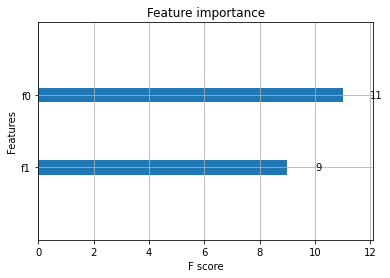

In [8]:
%matplotlib inline

# 1.绘制重要性
xgb.plot_importance(bst);

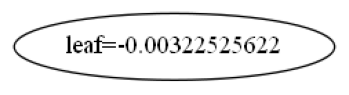

In [9]:
# 2.绘制输出树
xgb.plot_tree(bst, num_trees=2);

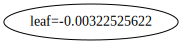

In [10]:
# 3.使用xgboost.to_graphviz()将目标树转换为graphviz
xgb.to_graphviz(bst, num_trees=2)

### 2.2 XGBoost分类案例

accuarcy: 100.00%


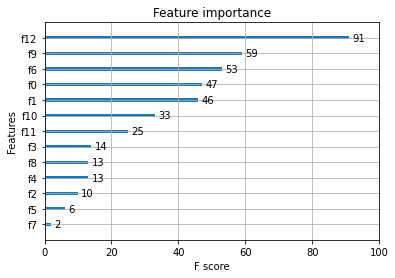

In [11]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score   # 准确率
# 加载样本数据集
wine = datasets.load_wine()
X,y = wine.data,wine.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234565) # 数据集分割

# 算法参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'eval_metric':'merror',
    'num_class': 3,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.75,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1,
    'nthread': 4,
}

plst = list(params.items())

dtrain = xgb.DMatrix(X_train, y_train) # 生成数据集格式
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds) # xgboost模型训练

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# 计算准确率
accuracy = accuracy_score(y_test,y_pred)
print("accuarcy: %.2f%%" % (accuracy*100.0))

# 显示重要特征
plot_importance(model)
plt.show()

### 2.3 XGBoost回归案例

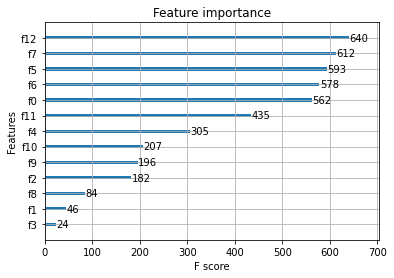

In [12]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

# 加载数据集
boston = load_boston()
X, y = boston.data, boston.target

# XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 300

plst = list(params.items())
model = xgb.train(plst, dtrain, num_rounds)

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)

# 显示重要特征
plot_importance(model)
plt.show()

### 2.4 LightGBM与网格搜索结合调参

In [13]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
 
canceData=load_breast_cancer()
X = canceData.data
y = canceData.target
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2)
 
### 数据转换
print('数据转换')
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,free_raw_data=False)
 
### 设置初始参数--不含交叉验证参数
print('设置参数')
params = { 'boosting_type': 'gbdt',
           'objective': 'binary',
           'metric': 'auc',
           'nthread': 4,
           'learning_rate': 0.1,
           'verbose': -1 }
 
### 交叉验证(调参)
print('交叉验证')
max_auc = float('0')
best_params = {}
 
# 准确率
print("调参1：提高准确率")
for num_leaves in range(5,100,5):
    for max_depth in range(3,8,1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth
 
        cv_results = lgb.cv(params,
                            lgb_train,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=False)
            
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
            
        if mean_auc >= max_auc:
            max_auc = mean_auc
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth
if 'num_leaves' and 'max_depth' in best_params.keys():          
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']
 
# 过拟合
print("调参2：降低过拟合")
for max_bin in range(5,256,10):
    for min_data_in_leaf in range(1,102,10):
            params['max_bin'] = max_bin
            params['min_data_in_leaf'] = min_data_in_leaf
            
            cv_results = lgb.cv(params,
                                lgb_train,
                                seed=1,
                                nfold=5,
                                metrics=['auc'],
                                early_stopping_rounds=10,
                                verbose_eval=False)
                    
            mean_auc = pd.Series(cv_results['auc-mean']).max()
            boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
            if mean_auc >= max_auc:
                max_auc = mean_auc
                best_params['max_bin']= max_bin
                best_params['min_data_in_leaf'] = min_data_in_leaf
if 'max_bin' and 'min_data_in_leaf' in best_params.keys():
    params['min_data_in_leaf'] = best_params['min_data_in_leaf']
    params['max_bin'] = best_params['max_bin']

print("调参3：降低过拟合")
for feature_fraction in [0.6,0.7,0.8,0.9,1.0]:
    for bagging_fraction in [0.6,0.7,0.8,0.9,1.0]:
        for bagging_freq in range(0,50,5):
            params['feature_fraction'] = feature_fraction
            params['bagging_fraction'] = bagging_fraction
            params['bagging_freq'] = bagging_freq
            
            cv_results = lgb.cv(params,
                                lgb_train,
                                seed=1,
                                nfold=5,
                                metrics=['auc'],
                                early_stopping_rounds=10,
                                verbose_eval=False)
                    
            mean_auc = pd.Series(cv_results['auc-mean']).max()
            boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
            if mean_auc >= max_auc:
                max_auc=mean_auc
                best_params['feature_fraction'] = feature_fraction
                best_params['bagging_fraction'] = bagging_fraction
                best_params['bagging_freq'] = bagging_freq

if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
    params['feature_fraction'] = best_params['feature_fraction']
    params['bagging_fraction'] = best_params['bagging_fraction']
    params['bagging_freq'] = best_params['bagging_freq']
 
 
print("调参4：降低过拟合")
for lambda_l1 in [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]:
    for lambda_l2 in [1e-5,1e-3,1e-1,0.0,0.1,0.4,0.6,0.7,0.9,1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(params,
                            lgb_train,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=False)
                
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
        if mean_auc >= max_auc:
            max_auc=mean_auc
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']

print("调参5：降低过拟合2")
for min_split_gain in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    params['min_split_gain'] = min_split_gain
    
    cv_results = lgb.cv(params,
                        lgb_train,
                        seed=1,
                        nfold=5,
                        metrics=['auc'],
                        early_stopping_rounds=10,
                        verbose_eval=False)
            
    mean_auc = pd.Series(cv_results['auc-mean']).max()
    boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
    if mean_auc >= max_auc:
        max_auc=mean_auc
        
        best_params['min_split_gain'] = min_split_gain
if 'min_split_gain' in best_params.keys():
    params['min_split_gain'] = best_params['min_split_gain']

print(best_params)

数据转换
设置参数
交叉验证
调参1：提高准确率
调参2：降低过拟合
调参3：降低过拟合
调参4：降低过拟合
调参5：降低过拟合2
{'num_leaves': 5, 'max_depth': 7, 'max_bin': 105, 'min_data_in_leaf': 51, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 45, 'lambda_l1': 0.001, 'lambda_l2': 0.0, 'min_split_gain': 0.0}
